In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %cd drive/MyDrive/Semester/3rd_sem/MSS/Project/MSS\ PROJECT/
%cd /content/drive/MyDrive/MSS PROJECT

/content/drive/MyDrive/MSS PROJECT


In [ ]:
%ls

 AnomalyDetection_final_version   autoencoder/            features/
 AnomalyDetection_v1.ipynb        DATASET/               'MSS  PRoject.ipynb'
 AnomalyDetection_v2             'DATASET OEP'/
 AnomalyDetection_v2.1            DATASET_OEP_FEATURES/


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.optimizers import Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
%ls ./DATASET_OEP_FEATURES/

test10.npy  test13.npy  test16.npy  test19.npy  test21.npy  test24.npy  test4.npy  test7.npy
test11.npy  test14.npy  test17.npy  test1.npy   test22.npy  test2.npy   test5.npy  test8.npy
test12.npy  test15.npy  test18.npy  test20.npy  test23.npy  test3.npy   test6.npy  test9.npy


## data load

In [ ]:
data = []
for i in range(1,23):
    if i==7:
        continue
    file_name = './DATASET_OEP_FEATURES/test{}.npy'.format(i)
    feature_vectors = np.load(file_name)
    print(file_name, 'shape', feature_vectors.shape)
    data.append(feature_vectors)

data = np.concatenate(data)
print(data.shape)

./DATASET_OEP_FEATURES/test1.npy shape (530, 1, 768)
./DATASET_OEP_FEATURES/test2.npy shape (557, 1, 768)
./DATASET_OEP_FEATURES/test3.npy shape (471, 1, 768)
./DATASET_OEP_FEATURES/test4.npy shape (549, 1, 768)
./DATASET_OEP_FEATURES/test5.npy shape (428, 1, 768)
./DATASET_OEP_FEATURES/test6.npy shape (439, 1, 768)
./DATASET_OEP_FEATURES/test8.npy shape (430, 1, 768)
./DATASET_OEP_FEATURES/test9.npy shape (531, 1, 768)
./DATASET_OEP_FEATURES/test10.npy shape (413, 1, 768)
./DATASET_OEP_FEATURES/test11.npy shape (456, 1, 768)
./DATASET_OEP_FEATURES/test12.npy shape (464, 1, 768)
./DATASET_OEP_FEATURES/test13.npy shape (480, 1, 768)
./DATASET_OEP_FEATURES/test14.npy shape (571, 1, 768)
./DATASET_OEP_FEATURES/test15.npy shape (753, 1, 768)
./DATASET_OEP_FEATURES/test16.npy shape (472, 1, 768)
./DATASET_OEP_FEATURES/test17.npy shape (471, 1, 768)
./DATASET_OEP_FEATURES/test18.npy shape (580, 1, 768)
./DATASET_OEP_FEATURES/test19.npy shape (368, 1, 768)
./DATASET_OEP_FEATURES/test20.npy sh

In [ ]:
# data = np.load('./features/test1.npy')

In [ ]:
data = data.reshape(data.shape[0],-1)
print(data.shape)

(10900, 768)


## softlabeling

In [ ]:
if_model = IsolationForest(n_estimators=100,max_samples='auto',contamination=float(0.2),random_state=42)
if_model.fit(data)

IsolationForest(contamination=0.2, random_state=42)

In [ ]:
test_data = np.load('./features/test7.npy')
test_data = test_data.reshape(test_data.shape[0],-1)

In [ ]:
labels = if_model.predict(test_data)

In [ ]:
#   -1 = anomaly
#    1 = normal
np.unique(labels, return_counts=True)

(array([-1]), array([576]))

In [ ]:
np.where(labels==-1)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

## AutoEncoder

In [ ]:
cosine_similarity(data[108].reshape(1,-1), data[0].reshape(1,-1))

array([[0.96244276]], dtype=float32)

In [ ]:
def cosine_similarity_scores(data):
    cosine_similarity_all = []
    for i in range(data.shape[0]):
        cosine_similarity_all.append(cosine_similarity(data[108].reshape(1,-1), data[i].reshape(1,-1))[0][0])
    return np.array(cosine_similarity_all)

scores = cosine_similarity_scores(data)

<Axes: ylabel='Density'>

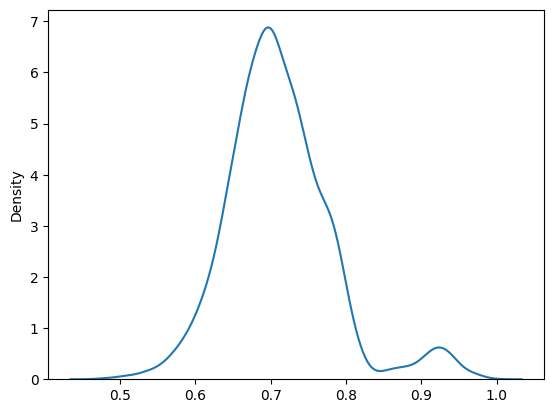

In [ ]:
sns.kdeplot(scores)

In [ ]:
# 1=normal, 0=anomaly
labels = np.where(scores>=0.65, 1, 0)

In [ ]:
data = data.reshape(data.shape[0],-1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

In [ ]:
train_index = np.where(y_train == 1)
train_data = x_train[train_index]

In [ ]:
# create a model by subclassing Model class in tensorflow
class AutoEncoder(Model):
    """
    Parameters
    ----------
    output_units: int
    Number of output units

    code_size: int
    Number of units in bottle neck
    """

    def __init__(self, output_units, code_size=8):
        super().__init__()
        self.encoder = Sequential([
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(code_size, activation='relu')
        ])
        self.decoder = Sequential([
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(output_units, activation='sigmoid')
            # Dense(output_units, activation='softmax')
        ])

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
x_train.shape

(8720, 768)

In [ ]:
model = AutoEncoder(output_units=x_train.shape[1])
# configurations of model
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
# model.compile(loss='msle', metrics=['accuracy'], optimizer='adam')
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

history = model.fit(
    x_train,
    x_train,
    epochs=100,
    batch_size=512,
    validation_data=(x_test, x_test),
    callbacks=[early_stopping]
)

Epoch 1/100
18/18 [==============================] - 2s 33ms/step - loss: 0.1099 - mse: 0.8470 - val_loss: 0.0724 - val_mse: 0.6568
Epoch 2/100
18/18 [==============================] - 0s 25ms/step - loss: 0.0706 - mse: 0.6424 - val_loss: 0.0629 - val_mse: 0.6194
Epoch 3/100
18/18 [==============================] - 0s 23ms/step - loss: 0.0654 - mse: 0.6208 - val_loss: 0.0620 - val_mse: 0.6144
Epoch 4/100
18/18 [==============================] - 0s 22ms/step - loss: 0.0639 - mse: 0.6145 - val_loss: 0.0619 - val_mse: 0.6168
Epoch 5/100
18/18 [==============================] - 0s 23ms/step - loss: 0.0630 - mse: 0.6103 - val_loss: 0.0603 - val_mse: 0.6068
Epoch 6/100
18/18 [==============================] - 0s 22ms/step - loss: 0.0612 - mse: 0.6024 - val_loss: 0.0575 - val_mse: 0.5944
Epoch 7/100
18/18 [==============================] - 0s 22ms/step - loss: 0.0591 - mse: 0.5936 - val_loss: 0.0562 - val_mse: 0.5874
Epoch 8/100
18/18 [==============================] - 0s 22ms/step - loss: 0.

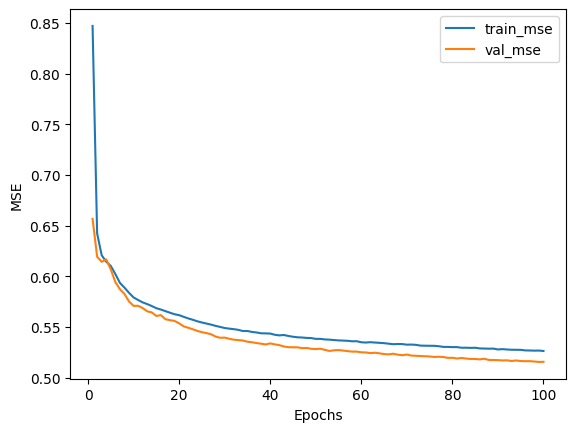

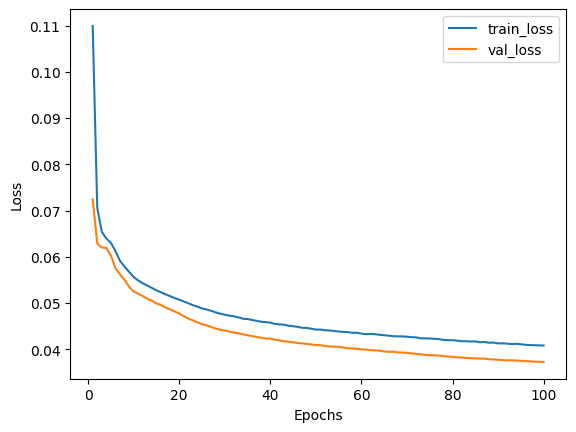

In [ ]:
# lists:training accuracy, validation accuracy, training loss, validation loss
train_acc = history.history['mse']
train_loss = history.history['loss']

val_acc = history.history['val_mse']
val_loss = history.history['val_loss']

# Plot Epochs Vs. training and validation accuracy
acc_df = pd.DataFrame(zip(train_acc,val_acc), columns = ['train_mse', 'val_mse'])
acc_df.index = np.arange(1,len(acc_df)+1,1)
acc_df[['train_mse', 'val_mse']].plot()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()



# Plot Epochs Vs. training and validation loss
los_df = pd.DataFrame(zip(train_loss,val_loss), columns = ['train_loss', 'val_loss'])
los_df.index = np.arange(1,len(los_df)+1,1)
los_df[['train_loss', 'val_loss']].plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [ ]:
x_test_pred = model.predict(x_test)

69/69 [==============================] - 0s 2ms/step


In [ ]:
x_test_pred

array([[5.2974191e-02, 8.7494969e-01, 5.2828103e-01, ..., 9.4517547e-04,
        9.9997282e-01, 1.1808245e-01],
       [2.3247138e-02, 9.9995035e-01, 4.4231263e-01, ..., 3.0057394e-04,
        9.9999988e-01, 2.8297785e-01],
       [2.3048106e-03, 4.4256040e-01, 1.4577994e-01, ..., 1.3224588e-02,
        9.9997514e-01, 3.2872371e-02],
       ...,
       [1.1148108e-02, 9.9787182e-01, 4.9119663e-01, ..., 3.4525838e-02,
        9.9986857e-01, 2.2734803e-01],
       [3.7996087e-02, 9.9800909e-01, 4.9482095e-01, ..., 1.8443248e-03,
        9.9999118e-01, 3.7621358e-01],
       [1.0426792e-02, 5.1271105e-01, 9.2514062e-01, ..., 1.8820381e-05,
        1.0000000e+00, 5.1415268e-02]], dtype=float32)

In [ ]:
x_test_pred.shape

(2180, 768)

In [ ]:
def cosine_similarity_scores_test_data(x,y):
    cosine_similarity_all = []
    for i in range(x.shape[0]):
        cosine_similarity_all.append(cosine_similarity(x[i].reshape(1,-1), y[i].reshape(1,-1))[0][0])
    scores = np.array(cosine_similarity_all)
    labels = np.where(scores>=0.65, 1, 0)
    return labels,scores

y_pred, y_pred_prob = cosine_similarity_scores_test_data(x_test, x_test_pred)

In [ ]:
y_pred_prob.shape, y_test.shape

((2180,), (2180,))

In [ ]:
accuracy_score(y_test, y_pred)

0.8302752293577982

## testing on randomdata

In [ ]:
test_data = np.load('./DATASET_OEP_FEATURES/test7.npy')
test_data = test_data.reshape(test_data.shape[0],-1)
test_data.shape

(460, 768)

In [ ]:
test_data_labels = if_model.predict(test_data)
test_data_labels[test_data_labels==-1] = 0

In [ ]:
#    0 = anomaly
#    1 = normal
np.unique(test_data_labels, return_counts=True)

(array([0, 1]), array([140, 320]))

In [ ]:
test_data_pred = model.predict(test_data)

15/15 [==============================] - 0s 2ms/step


In [ ]:
y_test_data_pred = cosine_similarity_scores_test_data(test_data, test_data_pred)

In [ ]:
np.where(y_test_data_pred==0)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [ ]:
# anomalies detected - secs
np.where(y_test_data_pred==0)[0]*2

array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
        26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
        52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
        78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100, 102,
       104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128,
       130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154,
       156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180,
       182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206,
       208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232,
       234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258,
       260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284,
       286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310,
       312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332, 334, 336,
       338, 340, 342, 344, 346, 348, 350, 352, 354, 356, 358, 36

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
test_data_labels.shape, y_pred_prob.shape

((460,), (2180,))

In [ ]:
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, y_pred_prob, pos_label=1)

# roc curve for tpr = fpr
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [ ]:
# auc scores
auc_score = roc_auc_score(y_test, y_pred_prob)
print(auc_score)

0.7870947802197802


<ipython-input-115-110669c1af8c>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


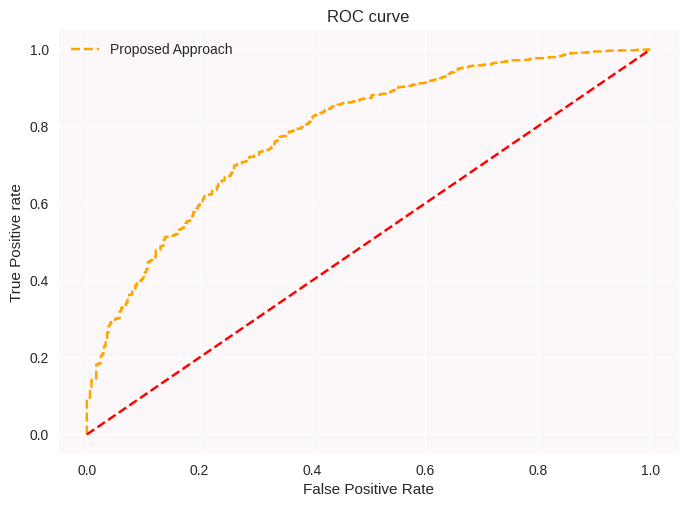

In [ ]:
plt.style.use('seaborn')

sns.set_style(rc = {'axes.facecolor': '#FCF7F9'})
# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Proposed Approach')
plt.plot(p_fpr, p_tpr, linestyle='--', color='red')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
# plt.savefig('ROC',dpi=300)
plt.savefig('/content/drive/MyDrive/Semester/MTP/Phishing-Detection/ROC.pdf')
plt.show();